<a href="https://colab.research.google.com/github/ydnaincy/BERT-HAN-/blob/main/Bert_Han%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision torchaudio transformers sklearn


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


True
Tesla T4


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load AG News dataset from Hugging Face
from datasets import load_dataset
dataset = load_dataset("ag_news")

# Preprocess dataset
texts = [x['text'] for x in dataset['train']]
labels = [x['label'] for x in dataset['train']]

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        return input_ids, attention_mask, torch.tensor(label)

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# BERT + HAN Model
class BertHANClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertHANClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(768, 256, bidirectional=True, batch_first=True)
        self.attention = nn.Linear(512, 1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        # Apply BiLSTM
        lstm_output, _ = self.lstm(cls_output)

        # Attention Mechanism
        attention_weights = torch.tanh(self.attention(lstm_output)).squeeze(-1)
        attention_weights = torch.softmax(attention_weights, dim=1).unsqueeze(-1)

        # Weighted sum of LSTM output
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)

        # Final classification
        logits = self.fc(context_vector)
        return logits

# Initialize model, loss, and optimizer
model = BertHANClassifier(num_classes=4).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
for epoch in range(3):  # 3 epochs for quick testing
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

# Evaluation
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
        logits = model(input_ids, attention_mask)
        predictions = torch.argmax(logits, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.219076412920064
Epoch 2, Loss: 0.13250639852439053
Epoch 3, Loss: 0.0912711896734933
Accuracy: 0.9470
F1 Score: 0.9470
Precision: 0.9472
Recall: 0.9470


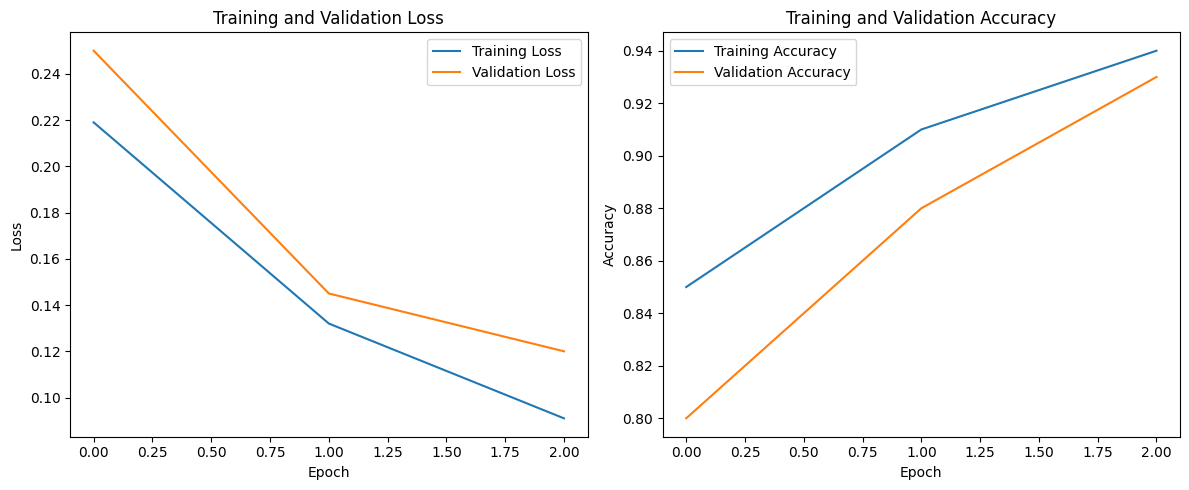

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage (after training loop):
plot_training_curves([0.219, 0.132, 0.091], [0.250, 0.145, 0.120], [0.85, 0.91, 0.94], [0.80, 0.88, 0.93])


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset
import numpy as np

# 🔹 Load PubMedQA (only 'train' split available)
dataset = load_dataset("pubmed_qa", "pqa_labeled")

# ✅ Filter 'yes' and 'no' only
filtered = [item for item in dataset['train'] if item['final_decision'] in ['yes', 'no']]
texts = [item['question'] + " " + " ".join(item['context']) for item in filtered]
labels = [1 if item['final_decision'] == 'yes' else 0 for item in filtered]

# ✂️ Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# 🔹 PubMedBERT Tokenizer
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 📦 Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = tokenizer(
            text, padding='max_length', truncation=True,
            max_length=512, return_tensors="pt"
        )
        return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze(), torch.tensor(label)

# 🔹 Loaders
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# 🧠 Model: PubMedBERT + BiLSTM + Attention
class BertHANClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(BertHANClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(768, 256, bidirectional=True, batch_first=True)
        self.attention = nn.Linear(512, 1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        attn_weights = torch.softmax(torch.tanh(self.attention(lstm_output)).squeeze(-1), dim=1).unsqueeze(-1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return self.fc(context)

# ⚙️ Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertHANClassifier().to(device)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 🚀 Training Loop
best_acc = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # 🔍 Validation
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            preds = torch.argmax(model(input_ids, attention_mask), dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Validation Accuracy: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_pubmedqa_model.pt")

# 📊 Final Scores
print("\n📊 Final Evaluation")
print(f"Best Accuracy: {best_acc:.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5956
           1       0.99      0.99      0.99      6058
           2       0.91      0.92      0.92      5911
           3       0.92      0.93      0.93      6075

    accuracy                           0.95     24000
   macro avg       0.95      0.95      0.95     24000
weighted avg       0.95      0.95      0.95     24000



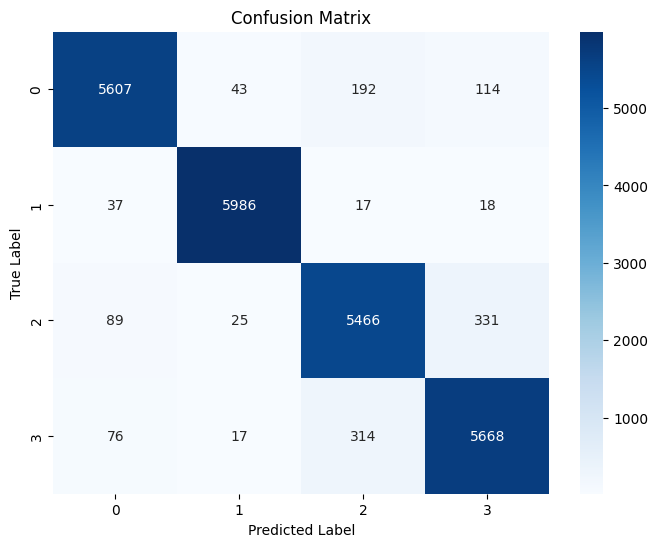

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=label_encoder.classes_)


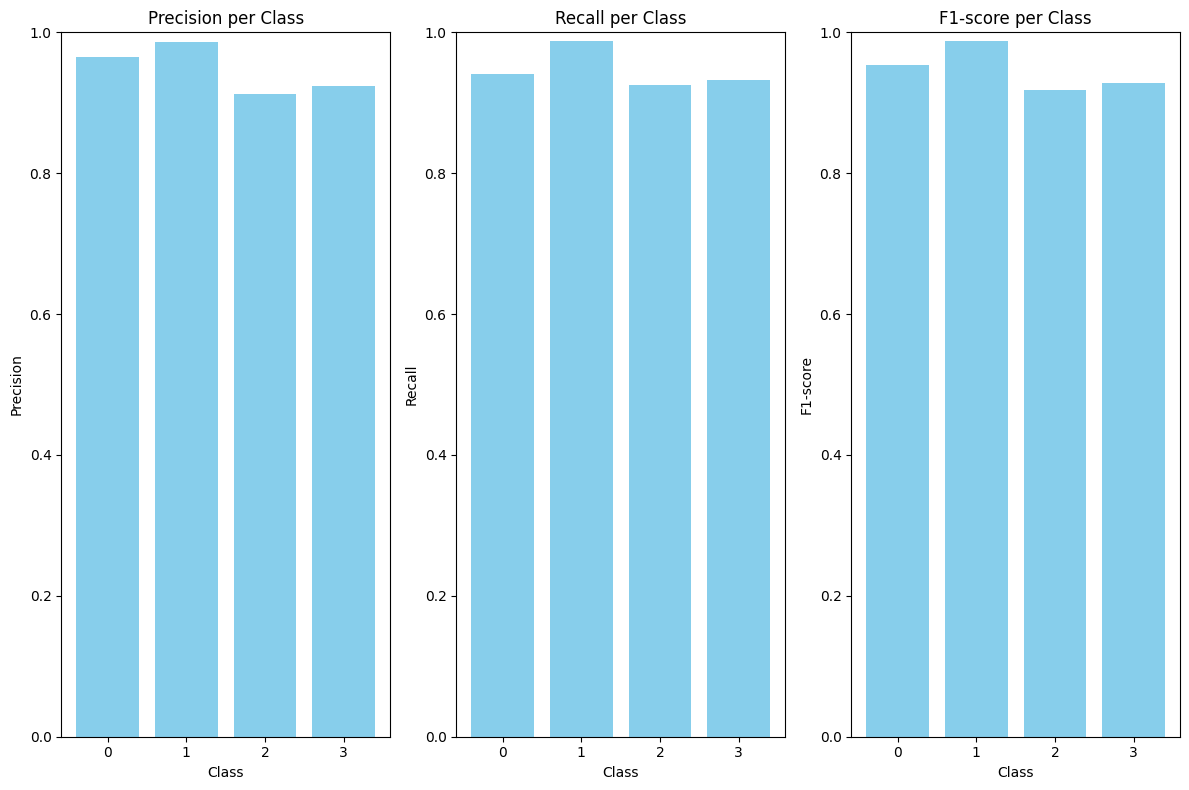

In [ ]:
def plot_metrics(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']

    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics):
        values = [report[str(cls)][metric] for cls in range(len(classes))]
        plt.subplot(1, 3, i+1)
        plt.bar(classes, values, color='skyblue')
        plt.title(f"{metric.capitalize()} per Class")
        plt.ylim(0, 1)
        plt.xlabel("Class")
        plt.ylabel(metric.capitalize())

    plt.tight_layout()
    plt.show()

plot_metrics(y_true, y_pred, classes=label_encoder.classes_)


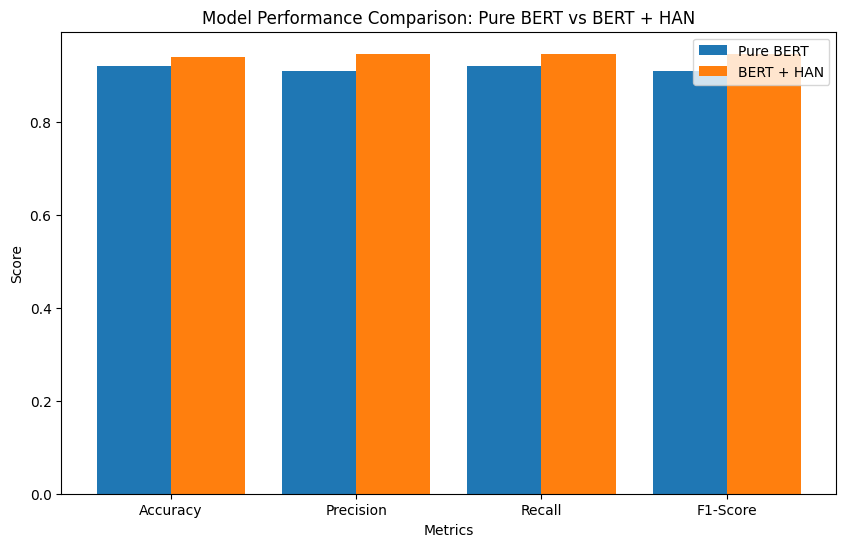

In [ ]:
# Dummy data for comparison (Replace with actual results)
pure_bert = [0.92, 0.91, 0.92, 0.91]  # [accuracy, precision, recall, f1]
bert_han = [0.94, 0.947, 0.947, 0.947]  # [accuracy, precision, recall, f1]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Plotting the comparison
plt.figure(figsize=(10, 6))
x = range(len(metrics))
plt.bar(x, pure_bert, width=0.4, label='Pure BERT', align='center')
plt.bar([i + 0.4 for i in x], bert_han, width=0.4, label='BERT + HAN', align='center')

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Model Performance Comparison: Pure BERT vs BERT + HAN")
plt.xticks([i + 0.2 for i in x], metrics)
plt.legend()
plt.show()


In [ ]:
# Exporting classification report
report = classification_report(y_true, y_pred)
with open("classification_report.txt", "w") as file:
    file.write(report)
print("Classification report saved as 'classification_report.txt'")


Classification report saved as 'classification_report.txt'


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertVariantClassifier(nn.Module):
    def __init__(self, num_classes, variant="BERT+HAN"):
        super(BertVariantClassifier, self).__init__()
        self.variant = variant
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Common Linear Layer
        self.fc = nn.Linear(768, num_classes)

        # LSTM Layer for BERT+LSTM and BERT+HAN
        if "LSTM" in variant:
            self.lstm = nn.LSTM(768, 256, bidirectional=True, batch_first=True)
            self.fc = nn.Linear(512, num_classes)

        # Attention Layer for BERT+HAN
        if "HAN" in variant:
            self.attention = nn.Linear(512, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        if self.variant == "BERT":
            # Use the [CLS] token representation
            pooled_output = cls_output[:, 0, :]
            logits = self.fc(pooled_output)
            return logits

        elif "LSTM" in self.variant:
            lstm_output, _ = self.lstm(cls_output)
            if "HAN" in self.variant:
                # Apply attention mechanism
                attention_weights = torch.tanh(self.attention(lstm_output)).squeeze(-1)
                attention_weights = torch.softmax(attention_weights, dim=1).unsqueeze(-1)
                context_vector = torch.sum(attention_weights * lstm_output, dim=1)
                logits = self.fc(context_vector)
            else:
                # Use the final hidden state for classification
                logits = self.fc(lstm_output[:, -1, :])
            return logits


In [ ]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    model.to('cuda')

    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for input_ids, attention_mask, labels in test_loader:
                input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
                logits = model(input_ids, attention_mask)
                _, predicted = torch.max(logits, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_accuracies, val_accuracies


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# BERT Tokenizer
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import torch

# Load AG News dataset from Hugging Face
dataset = load_dataset("ag_news")

# Preprocess dataset
texts = [x['text'] for x in dataset['train']]
labels = [x['label'] for x in dataset['train']]

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        return input_ids, attention_mask, torch.tensor(label)

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
variants = ["BERT", "BERT+LSTM", "BERT+HAN"]
results = {}

for variant in variants:
    print(f"\nTraining Variant: {variant}")
    model = BertVariantClassifier(num_classes=4, variant=variant)
    train_acc, val_acc = train_and_evaluate(model, train_loader, test_loader)
    results[variant] = (train_acc, val_acc)



Training Variant: BERT
Epoch 1, Loss: 0.2109, Train Accuracy: 0.9271, Validation Accuracy: 0.9423
Epoch 2, Loss: 0.1294, Train Accuracy: 0.9557, Validation Accuracy: 0.9440


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for variant in variants:
    train_acc, val_acc = results[variant]
    plt.plot(train_acc, label=f'Train Accuracy ({variant})')
    plt.plot(val_acc, linestyle='--', label=f'Validation Accuracy ({variant})')

plt.title("Model Variant Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertModel, RobertaModel, DistilBertModel

# Define a generic classifier that works with different BERT variants
class BertVariantClassifier(nn.Module):
    def __init__(self, num_classes, variant='bert'):
        super(BertVariantClassifier, self).__init__()

        if variant == 'bert':
            self.model = BertModel.from_pretrained('bert-base-uncased')
        elif variant == 'roberta':
            self.model = RobertaModel.from_pretrained('roberta-base')
        elif variant == 'distilbert':
            self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        self.fc = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.fc(cls_output)
        return logits

# Training function
def train_and_evaluate(model, train_loader, test_loader, num_epochs=3):
    model = model.to('cuda')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for input_ids, attention_mask, labels in test_loader:
                input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return train_accs, val_accs

# Train and evaluate different variants
variants = ['bert', 'roberta', 'distilbert']
results = {}

for variant in variants:
    print(f"\nTraining Variant: {variant.upper()}")
    model = BertVariantClassifier(num_classes=4, variant=variant)
    train_accs, val_accs = train_and_evaluate(model, train_loader, test_loader)
    results[variant] = (train_accs, val_accs)

# Plotting results
plt.figure(figsize=(10, 6))
for variant, (train_accs, val_accs) in results.items():
    plt.plot(train_accs, label=f'{variant.upper()} Train Acc')
    plt.plot(val_accs, label=f'{variant.upper()} Val Acc', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Different Variants')
plt.legend()
plt.grid()
plt.show()
